<a href="https://colab.research.google.com/github/s-sridhar24/EVA4-S5/blob/master/play_EVA4S5F3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Program Targets:

Consistent accuracy of 99.4%

Achieve using less than 10K parameters and in <= 15 epochs

Share this as 5 steps with obj, analysis for each step


# Step 3 Objectives:

Reduce the parameters, reduce overfitting

Parameters rationalized in architecture

Include small rate of dropout


# Step 3 results and analysis

Experimented with various configurations and arrived at this set

Tried maxpool after every RF of 5 versus a GAP before L-1 layer. The difference was not much so retained GAP at the end.

This resulted in parameters reduction to 11,172

**Performance:**

Important learning. Each execution gives different results. I got 99.3 and 99.4 several times but did not run the graph cell at the end. So re ran and ended up getting lesser performance. Will be good to get your views on this.

The gap between Train and Test is not justifying inclusion of a drop out, experimented with a small number. Though gap between trg and test is low, drop out helps push the test results to be in narrower range and more consistent over epochs.

*Myrtle.ai blog by David Page recommends using 32 as batch size for batchnormalization. Tried that (had a small improvement in performance)*

Same blog recommended CELU over ReLU, I did not see any change. Sticking to ReLU.

** Plan for Step 4 **

Retain performance, reduce Parameters below 10K using these rationale:

Prefer to use fewer parameters in early layers and retain more for later

Prefer depth to breadth





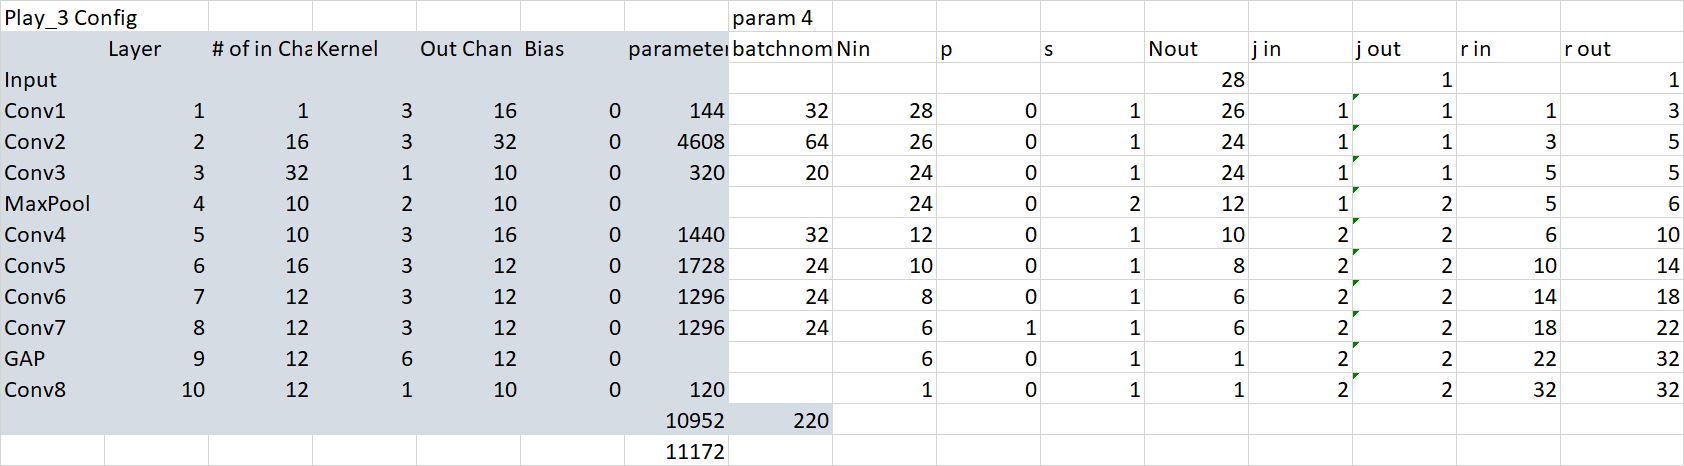

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#dataloader_args = dict(shuffle=True, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


TypeError: ignored

# Data Statistics

Same dataset so not important in this step

# The model


In [0]:
import torch.nn.functional as F
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
             ReLU-10           [-1, 10, 24, 24]               0
      BatchNorm2d-11           [-1, 10, 24, 24]              20
          Dropout-12           [-1, 10, 24, 24]               0
        MaxPool2d-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [16]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.036050766706466675 Batch_id=1874 Accuracy=94.07: 100%|██████████| 1875/1875 [00:27<00:00, 78.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9840/10000 (98.40%)

EPOCH: 1


Loss=0.02222101390361786 Batch_id=1874 Accuracy=98.22: 100%|██████████| 1875/1875 [00:26<00:00, 69.54it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9900/10000 (99.00%)

EPOCH: 2


Loss=0.03239883482456207 Batch_id=1874 Accuracy=98.47: 100%|██████████| 1875/1875 [00:26<00:00, 69.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9912/10000 (99.12%)

EPOCH: 3


Loss=0.011262238025665283 Batch_id=1874 Accuracy=98.63: 100%|██████████| 1875/1875 [00:27<00:00, 69.05it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9915/10000 (99.15%)

EPOCH: 4


Loss=0.004012763500213623 Batch_id=1874 Accuracy=98.78: 100%|██████████| 1875/1875 [00:27<00:00, 69.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.0021077394485473633 Batch_id=1874 Accuracy=98.88: 100%|██████████| 1875/1875 [00:27<00:00, 68.65it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.0670837014913559 Batch_id=1874 Accuracy=98.97: 100%|██████████| 1875/1875 [00:26<00:00, 69.80it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.003284141421318054 Batch_id=1874 Accuracy=99.02: 100%|██████████| 1875/1875 [00:27<00:00, 69.41it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.00407041609287262 Batch_id=1874 Accuracy=99.03: 100%|██████████| 1875/1875 [00:27<00:00, 69.33it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.07853575050830841 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [00:27<00:00, 69.15it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.0007030367851257324 Batch_id=1874 Accuracy=99.18: 100%|██████████| 1875/1875 [00:27<00:00, 69.32it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.00041997432708740234 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [00:26<00:00, 75.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.0005770325660705566 Batch_id=1874 Accuracy=99.16: 100%|██████████| 1875/1875 [00:26<00:00, 69.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.07409805059432983 Batch_id=1874 Accuracy=99.22: 100%|██████████| 1875/1875 [00:26<00:00, 69.46it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.003212660551071167 Batch_id=1874 Accuracy=99.21: 100%|██████████| 1875/1875 [00:27<00:00, 69.14it/s]



Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)



Text(0.5, 1.0, 'Test Accuracy')

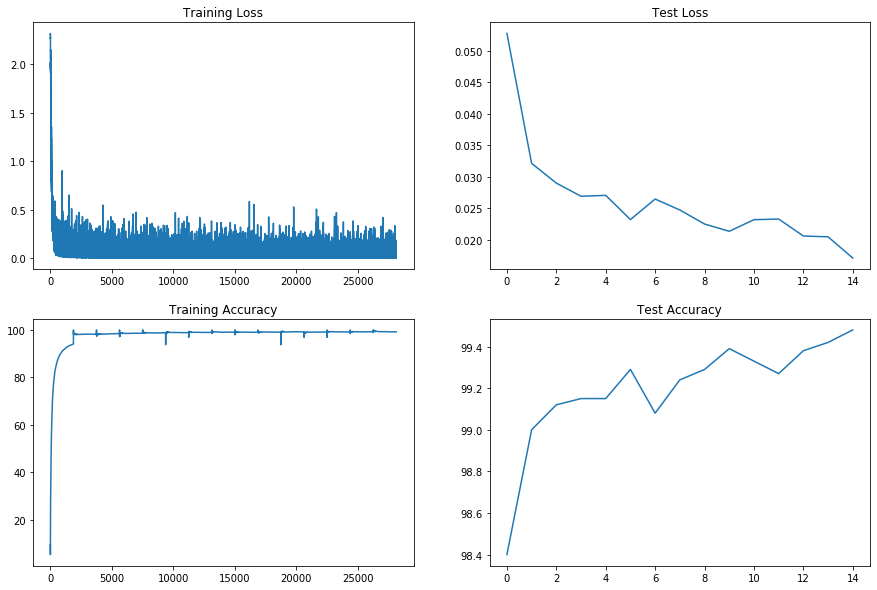

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")